# Principal Component Analysis on Swiss Roll Dataset

The main approaches for Dimensionality Reduction are **Projection** and **Manifold Learning**. **Projection** is when every training instance is perpendicularly projected into its subspace. From this, we get a new 2D dataset that has new features, but not all datasets are applicable for projections like the Swiss Roll dataset that has twists and turns.

**Swiss Roll** is an example of a 2D manifold. A 2D manifold is a 2D shape that can be bent and twisted in a higher-dimensional space. **Manifold Learning** assumes that:  

-  most real-world high-dimensional datasets lie close to a much lower-dimensional manifold 
-  the task at hand will be simpler if expressed in lower-dimensional space of the manifold

In this notebook, we will try to determine how the kernel trick can be applied to PCA to perform complex nonlinear projections on a 2D manifold like the Swiss Roll. 

In [2]:
# Generate Swiss Roll dataset

from sklearn.datasets import make_swiss_roll
X_swiss, t = make_swiss_roll(n_samples=1000, noise=0.2, random_state=42)

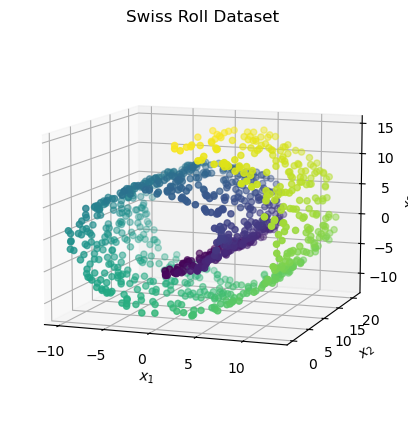

In [3]:
# Plot the Swiss Roll dataset
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_swiss[:, 0], X_swiss[:, 1], X_swiss[:, 2], c=t, cmap=plt.cm.viridis)
ax.view_init(10, -70)
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
ax.set_zlabel('$x_3$')
plt.title('Swiss Roll Dataset')
plt.show()

The kernel relies heavily on the parameters set for gamma and coefficients. Given a different gamma value, sigmoid kernel will show a different plot.

In [4]:
# Use kPCA with linear kernel, rbf kernel, and sigmoid kernel
from sklearn.decomposition import KernelPCA

lin_kpca = KernelPCA(kernel = "linear")
rbf_kpca = KernelPCA(kernel = "rbf", gamma=0.04)
sig_kpca = KernelPCA(kernel= "sigmoid", gamma=1e-3, coef0=1)

kernel_pcas = ((lin_kpca, "Linear kernel"),
               (rbf_kpca, rf"RBF kernel, $\gamma={rbf_kpca.gamma}$"),
               (sig_kpca, rf"Sigmoid kernel, $\gamma={sig_kpca.gamma}, r={sig_kpca.coef0}$"))


Projected on a 2D space, below are the comparison of the results depending on the kernel used.

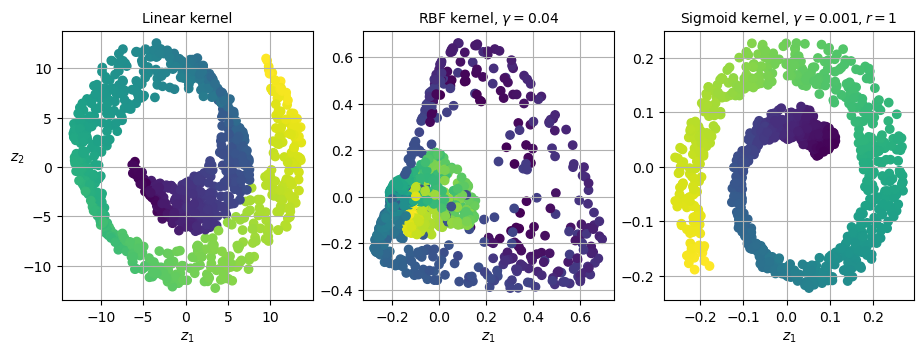

In [5]:
# Plot kPCA results 
plt.figure(figsize=(11, 3.5))
for idx, (kpca, title) in enumerate(kernel_pcas):
    kpca.n_components = 2
    kpca.random_state = 42
    X_swiss_reduced = kpca.fit_transform(X_swiss)

    plt.subplot(1, 3, idx + 1)
    plt.title(title, fontsize=10)
    plt.scatter(X_swiss_reduced[:, 0], X_swiss_reduced[:, 1], c=t, cmap=plt.cm.viridis)
    plt.xlabel("$z_1$")
    if idx == 0:
        plt.ylabel("$z_2$", rotation=0)
    plt.grid(True)
    
plt.show()

To determine the best parameters to be used in training the model, GridSearchCV is used. The best parameter gamma is at 0.03 but the kernel is linear which does not utlize this kernel coefficient. On the other hand, the result should be acceptable because the best score is at 87%.

In [26]:
# Apply Logistic Regression for classification using kPCA and sigmoid kernel
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
import numpy as np

clf = Pipeline([
    ("kpca", KernelPCA(n_components=2)),
    ("log_reg", LogisticRegression(max_iter=2000))
])

param_grid = [{
    "kpca__gamma": np.linspace(0.03, 0.05, 10),
    "kpca__kernel": ["linear","rbf","sigmoid"]
}]

# Discretize the target variable into 10 bins
from sklearn.preprocessing import KBinsDiscretizer

kbins = KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='uniform')

# Discretize the target variable into 10 bins and convert to integer type for classification
t_discrete = kbins.fit_transform(t.reshape(-1, 1)).astype(int).ravel()

grid_search = GridSearchCV(clf, param_grid, cv=3)
grid_search.fit(X_swiss, t_discrete)

# Output the best parameters
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best Score: {grid_search.best_score_}")

Best Parameters: {'kpca__gamma': 0.03, 'kpca__kernel': 'linear'}
Best Score: 0.8709218200236163


Using the best parameters to train the model, the plot is shown below. After kPCA, it became easier to determine where the classes lie as opposed to when the Swiss Roll was in its original dimensionality.

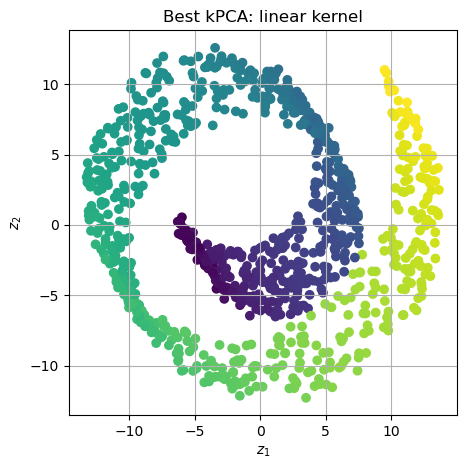

In [27]:
# Use best parameters from grid_search and plot
best_params = {key.split('__')[1]: value for key, value in grid_search.best_params_.items()}
best_kpca = KernelPCA(n_components=2, **best_params)
X_reduced = best_kpca.fit_transform(X_swiss)

plt.figure(figsize=(5, 5))
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=t, cmap=plt.cm.viridis)
plt.xlabel("$z_1$")
plt.ylabel("$z_2$")
plt.title(f"Best kPCA: {best_params['kernel']} kernel")
plt.grid(True)
plt.show()